# HL02 - smooth hydraulic level

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import stripy
import pandas as pd
%matplotlib inline

extent_globe = [-180,180,-90,90]
extent_australia = [112, 155, -44, -10]

In [3]:
gw_lon, gw_lat, gw_level, gw_level_std = np.loadtxt('../Data/NGIS_groundwater_levels_AUS.csv',
                                         delimiter=',', usecols=(2,3,8,9), skiprows=1, unpack=True)

gw_lonlat = np.column_stack([gw_lon, gw_lat])

## Setup mesh

In [4]:
# remove duplicate coordinates
unique_gw_lonlat, uindex = np.unique(np.radians(gw_lonlat.astype(np.float32)), return_index=True, axis=0)
unique_gw_level = gw_level[uindex]

# stripy mesh
mesh = stripy.sTriangulation(unique_gw_lonlat[:,0], unique_gw_lonlat[:,1], permute=True)

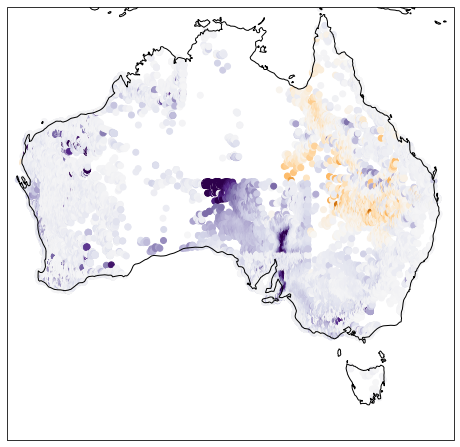

In [5]:
proj = ccrs.Mercator(central_longitude=160)


fig = plt.figure(figsize=(8,10))

ax = plt.axes(projection=proj)
ax.set_extent(extent_australia)
ax.coastlines()

vmax = np.percentile(np.abs(gw_level), 99)
vmin = -vmax

sc = ax.scatter(np.degrees(mesh.lons), np.degrees(mesh.lats), c=unique_gw_level, cmap='PuOr', vmin=vmin, vmax=vmax,
                transform=ccrs.PlateCarree())

In [6]:
# error on evaluating gradient - why??
grad_arrays = mesh.gradient_xyz(unique_gw_level)
np.count_nonzero(grad_arrays[0])

/home/ben/.local/lib/python3.7/site-packages/stripy/spherical.py:499: UserWarning: ierr=-3 in gradg
duplicate nodes were encountered.
  warnings.warn('ierr={} in gradg\n{}'.format(ierr, _ier_codes[ierr]))


0

## Smoothing

In [6]:
# what the doc

w     = np.full(mesh.npoints, 1.0/(np.std(unique_gw_level)**2))
sm    = 0.5*(mesh.npoints - np.sqrt(2*mesh.npoints) + mesh.npoints + np.sqrt(2*mesh.npoints))
smtol = np.sqrt(2.0/mesh.npoints)
gstol = 0.05*np.std(unique_gw_level)**2
sigma = mesh.get_spline_tension_factors(unique_gw_level, tol=1e-6)

In [7]:
smooth_gw_level, (dgw_x,dgw_y,dgw_z), ier = mesh.smoothing(unique_gw_level, w, sm, 0.99999, gstol)

/home/ben/.local/lib/python3.7/site-packages/stripy/spherical.py:564: UserWarning: No errors were encountered but the constraint is not active --
F, FX, and FY are the values and partials of a linear function which minimizes Q2(F), and Q1 = 0.
  F, FX, and FY are the values and partials of a linear function which minimizes Q2(F), and Q1 = 0.")


In [8]:
np.count_nonzero(dgw_x), dgw_x, dgw_y, dgw_z

(0,
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

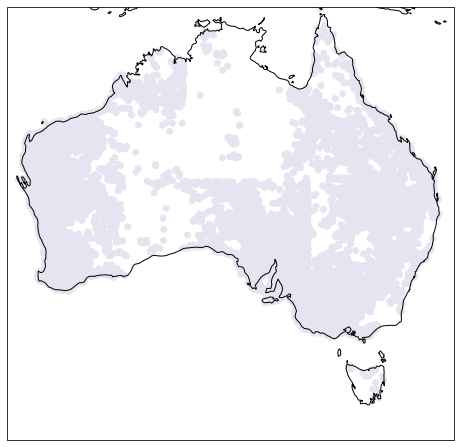

In [9]:
proj = ccrs.Mercator(central_longitude=160)


fig = plt.figure(figsize=(8,10))

ax = plt.axes(projection=proj)
ax.set_extent(extent_australia)
ax.coastlines()

vmax = np.percentile(np.abs(gw_level), 99)
vmin = -vmax

sc = ax.scatter(np.degrees(mesh.lons),
                np.degrees(mesh.lats), c=smooth_gw_level, cmap='PuOr', vmin=vmin, vmax=vmax,
                transform=ccrs.PlateCarree())

## Grid

In [14]:
nlon = int((extent_australia[1] - extent_australia[0])/0.5)
nlat = int((extent_australia[3] - extent_australia[2])/0.5)
lon_grid = np.linspace(extent_australia[0], extent_australia[1], nlon)
lat_grid = np.linspace(extent_australia[2], extent_australia[3], nlat)
lonq, latq = np.meshgrid(lon_grid, lat_grid)

gw_level_grid,ierr = mesh.interpolate(np.radians(lonq.ravel()), np.radians(latq.ravel()), smooth_gw_level, order=1)
gw_level_grid = gw_level_grid.reshape(lonq.shape)

In [16]:
# this will definitely fail !
# gw_level_grid = mesh.interpolate_to_grid(np.radians(lon_coords), np.radians(lat_coords), smooth_gw_level)

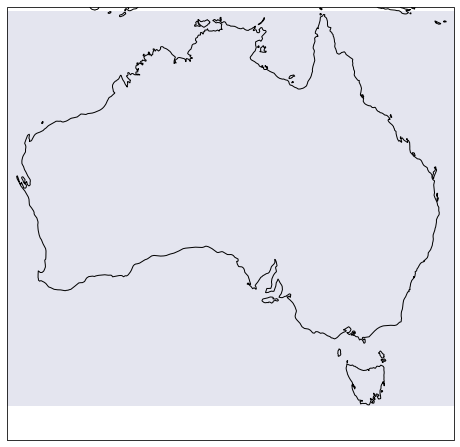

In [18]:
proj = ccrs.Mercator(central_longitude=160)


fig = plt.figure(figsize=(8,10))

ax = plt.axes(projection=proj)
ax.set_extent(extent_australia)
ax.coastlines()

vmax = np.percentile(np.abs(gw_level), 99)
vmin = -vmax

ax.imshow(gw_level_grid, extent=extent_australia, origin='lower', cmap='PuOr', vmin=vmin, vmax=vmax,
          transform=ccrs.PlateCarree(),)